- 철강데이터

- 종속변수 : target

#### 1. EDA(탐색적 데이터 분석)을 하시오.

In [29]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data=pd.read_csv("problem1.csv")
data.head(3)

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,target
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1


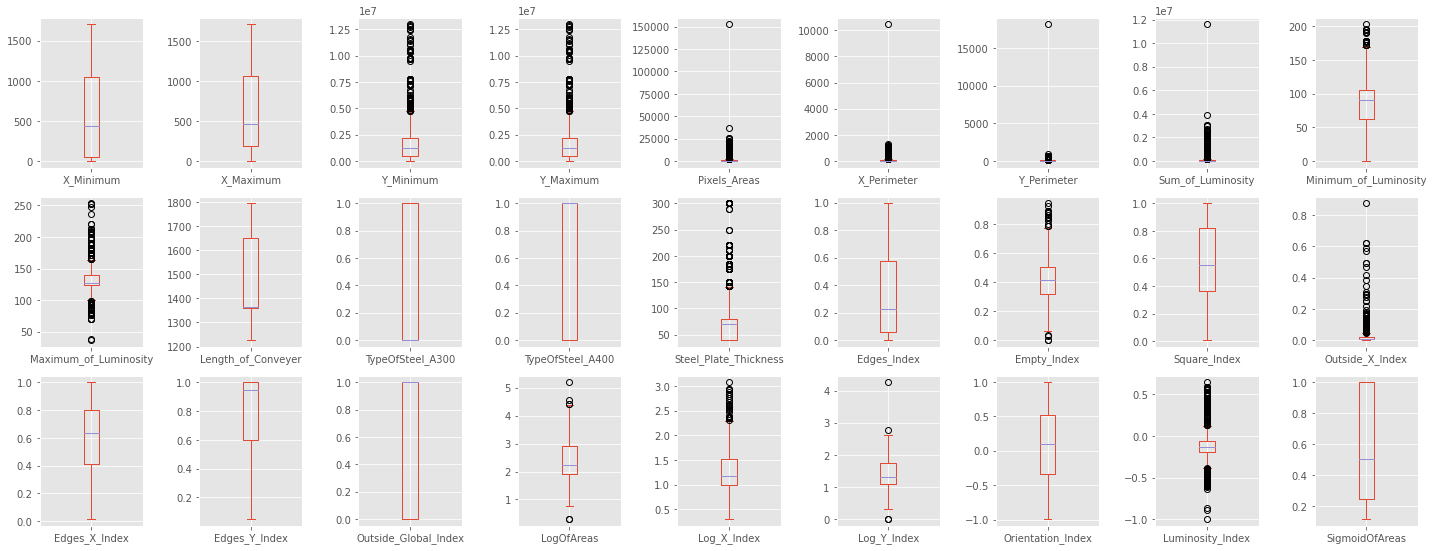

In [30]:
data.drop(columns=['target']).plot(kind='box', subplots=True, layout=(4,9), figsize=(20,10))
plt.tight_layout()
plt.show()

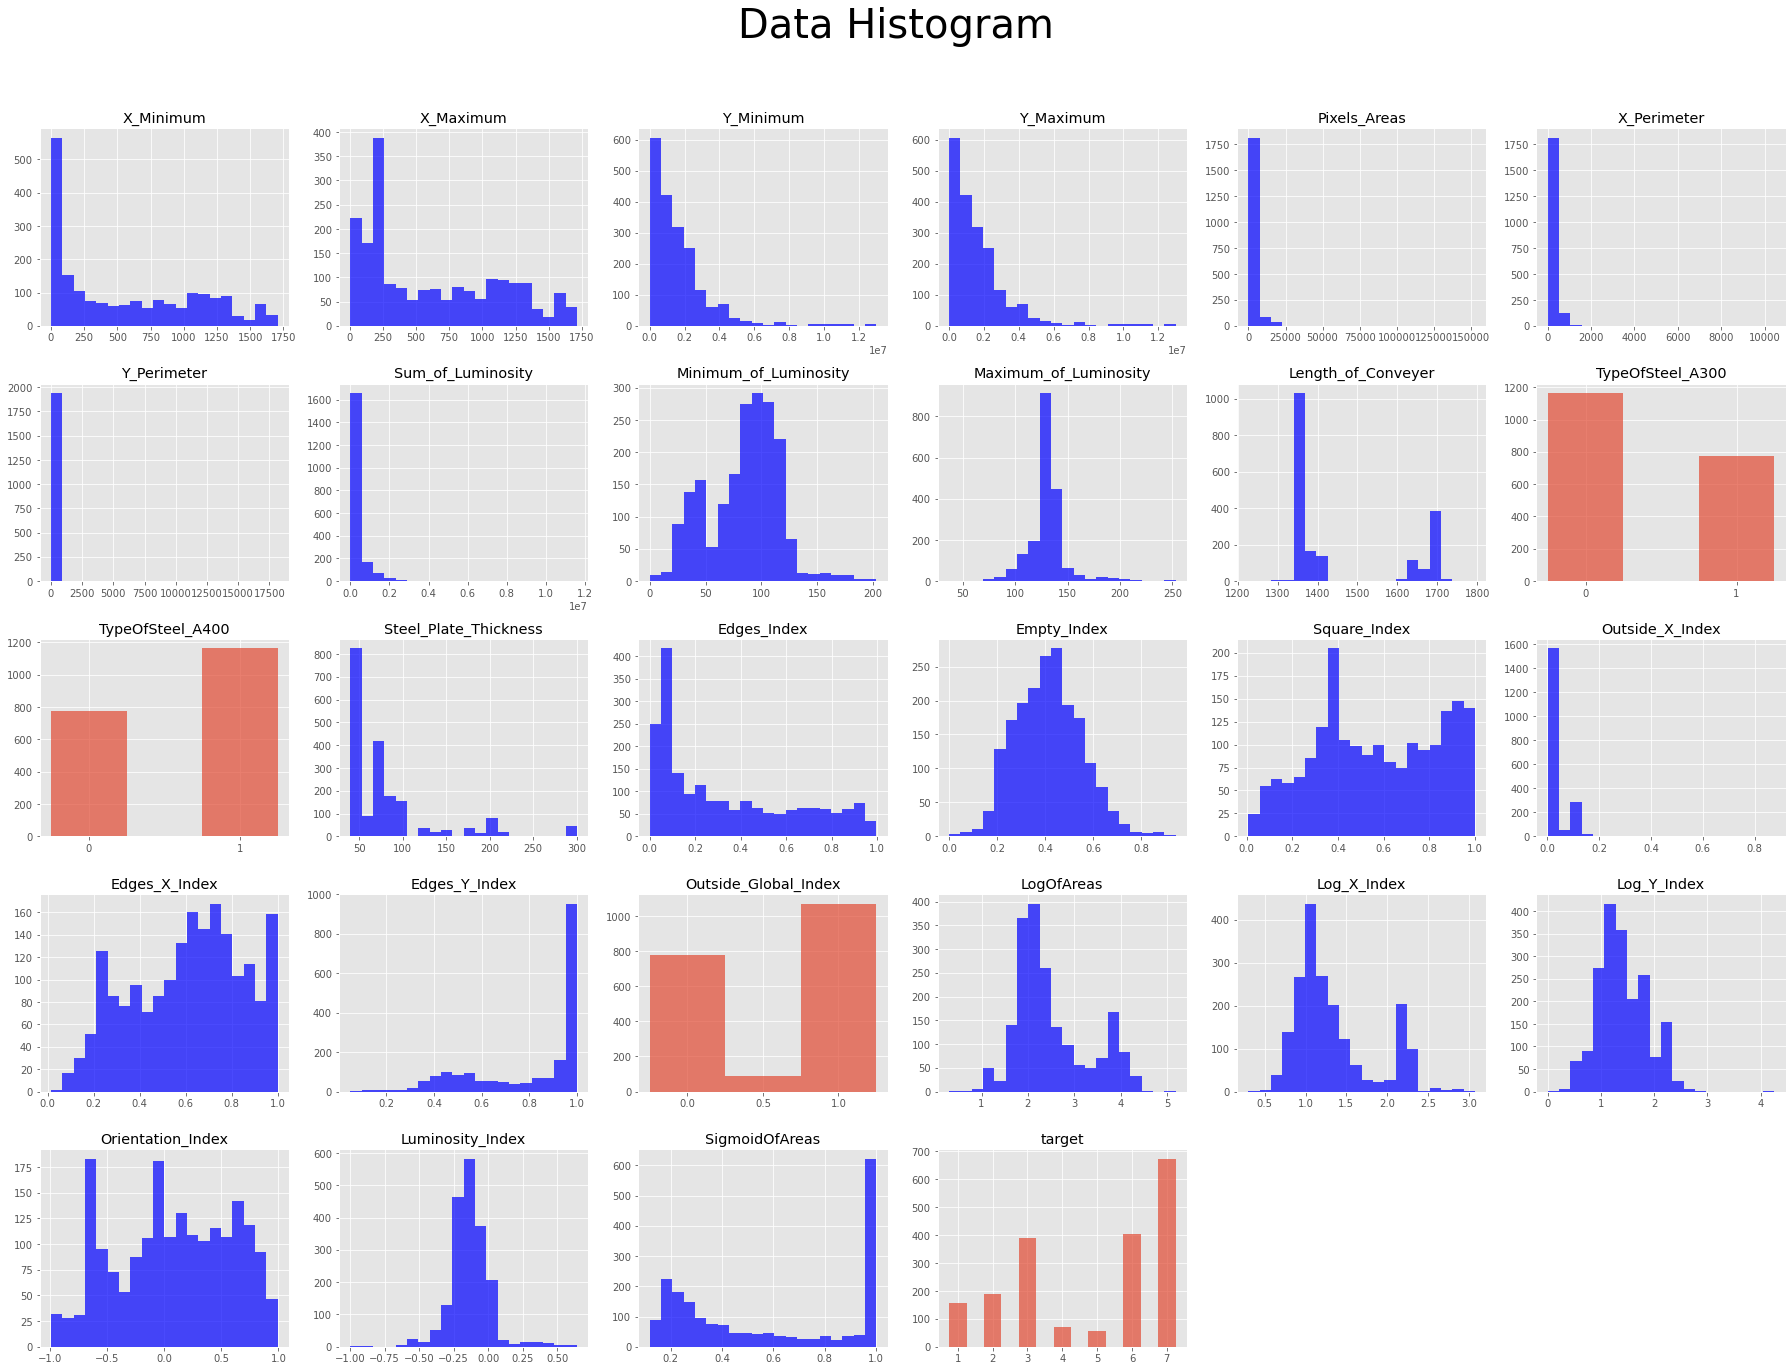

In [31]:
plt.style.use('ggplot')

plt.figure(figsize=(25,20))
plt.suptitle("Data Histogram", fontsize=40)

cols=data.columns
for i in range(len(cols)):
    plt.subplot(5,6, i+1)
    plt.title(cols[i])
    if len(data[cols[i]].unique())>20:
        plt.hist(data[cols[i]], bins=20, color='b', alpha=0.7)
        
    else:
        temp=data[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### 2. 변수선택(VIF), 파생변수 생성, 데이터 분할(train/test 20%)
(시각화와 통계량을 제시할 것)

In [32]:
#다중회귀
from statsmodels.formula.api import ols
#다중공선성(VIF) 계산
from statsmodels.stats.outliers_influence import variance_inflation_factor

data['average']=(data['X_Minimum']+data['X_Maximum'])/2
value="+".join(list(data.drop(columns=['target']).columns))

model=ols(f'target~{value}', data=data)

#회귀계수
model.exog_names

['Intercept',
 'X_Minimum',
 'X_Maximum',
 'Y_Minimum',
 'Y_Maximum',
 'Pixels_Areas',
 'X_Perimeter',
 'Y_Perimeter',
 'Sum_of_Luminosity',
 'Minimum_of_Luminosity',
 'Maximum_of_Luminosity',
 'Length_of_Conveyer',
 'TypeOfSteel_A300',
 'TypeOfSteel_A400',
 'Steel_Plate_Thickness',
 'Edges_Index',
 'Empty_Index',
 'Square_Index',
 'Outside_X_Index',
 'Edges_X_Index',
 'Edges_Y_Index',
 'Outside_Global_Index',
 'LogOfAreas',
 'Log_X_Index',
 'Log_Y_Index',
 'Orientation_Index',
 'Luminosity_Index',
 'SigmoidOfAreas',
 'average']

- 다중공선성 계산

In [33]:
vif = pd.DataFrame({'col': col, 'VIF': variance_inflation_factor(model.exog, i)} 
                   for i, col in enumerate(model.exog_names[1:])).sort_values('VIF',ascending=False)

vif.head(3)

,col,VIF
13,Steel_Plate_Thickness,inf
1,X_Maximum,inf
2,Y_Minimum,inf


vif값이 10 미만인 Outside_Global_Index,Maximum_of_Luminosity , Length_of_Conveyer, LogOfAreas, Edges_Y_Index, TypeOfSteel_A300, Outside_X_Index, Empty_Index, Edges_Index, X_Minimum, av 정도가 다중공선성이 없는 변수로 판단한다

In [34]:
#다중공선성이 10보다 작은 변수들 확인
list(vif[vif.VIF<10].col.values)

['average',
 'Outside_Global_Index',
 'Maximum_of_Luminosity',
 'Length_of_Conveyer',
 'LogOfAreas',
 'Edges_Y_Index',
 'TypeOfSteel_A300',
 'Outside_X_Index',
 'Empty_Index',
 'Edges_Index',
 'X_Minimum']

- 다중공선성이 10보다 작은 변수+y변수만 저장

In [35]:
#다중공선성이 10보다 작은 변수+y변수(target)만 저장
data2 = data.copy()[list(vif[vif.VIF<10].col.values)+['target']]

In [36]:
data2.head(3)

,average,Outside_Global_Index,Maximum_of_Luminosity,Length_of_Conveyer,LogOfAreas,Edges_Y_Index,TypeOfSteel_A300,Outside_X_Index,Empty_Index,Edges_Index,X_Minimum,target
0,46.0,1.0,108,1687,2.4265,1.0000,1,0.0047,0.2415,0.0498,42,1
1,648.0,1.0,123,1687,2.0334,0.9667,1,0.0036,0.3793,0.7647,645,1
2,832.0,1.0,125,1623,1.8513,0.9474,1,0.0037,0.3426,0.9710,829,1


- x,y split

In [37]:
from sklearn.model_selection import train_test_split

X=data2.drop(columns=['target'])
y=data2[['target']]

X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=32, test_size=0.2, stratify=y)

#### 3. 종속변수들중 "1"인지 아닌지 판단하려한다. 종속변수를 1과 1이 아닌 값(이항)으로 치환하고 로지스틱 회귀 분석을 실시하라.
confusionMatrix를 확인하고 cutoff value를 정하여라

- y변수 0/1변환

In [38]:
y_train1=y_train.copy()
y_test1=y_test.copy()
y_train1.loc[y_train1.target!=1, 'target']=0
y_test1.loc[y_test1.target!=1, 'target']=0

- 로지스틱 회귀분석

In [39]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(solver='liblinear')
model.fit(X_train.values, y_train1.values)

pred=model.predict(X_test)
y_prob=model.predict_proba(X_test)

from sklearn.metrics import classification_report, roc_curve

print(classification_report(y_test1, pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       357
           1       0.33      0.06      0.11        32

    accuracy                           0.91       389
   macro avg       0.63      0.53      0.53       389
weighted avg       0.87      0.91      0.88       389



- roc curve, cutoff 구하기

In [40]:
fpr, tpr, thresholds=roc_curve(y_test1.values, y_prob[:,1], pos_label=1)
J=tpr-fpr
ix=np.argmax(J)
cutoff=thresholds[ix]
cutoff

0.07214838853961467

#### 4. 종속변수(y)를 다항(7 class)인 상태에서 SVM을 포함하여 3가지 알고리즘으로 평가하라.
각 모델에서 confusionMatrix를 확인하고 최적의 cut off value 를 정하여라

#### 5. 종속변수를 제외한 나머지 데이터를 바탕으로 군집분석을 실시하고 최적의 군집수와 군집 레이블을 구하여라.

In [41]:
from sklearn.model_selection import train_test_split

X=data2.drop(columns=['target'])
y=data2['target']

X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=32, test_size=0.2, stratify=y)

In [42]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score

for k in range(2,10):
    kmeans_model=KMeans(n_clusters=k, random_state=1).fit(X_train)
    labels=kmeans_model.labels_
    print(calinski_harabasz_score(X_train, labels))

5436.637268643928
5822.108457992098
5761.094025355122
5871.463695731347
5979.201113077007
5905.637289629865
5968.354090006244
6138.831327821317


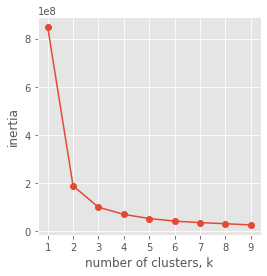

In [43]:
lst=[]
for k in range(1, 10):
    model=KMeans(n_clusters=k)
    model.fit(X_train)
    lst.append(model.inertia_)

plt.figure(figsize=(4,4))
plt.plot(range(1, 10), lst, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(range(1,10))
plt.show()

k값이 2에서 3으로 갈 떄 기울기 소실이 발생하므로, 2~3개의 군집이 적절함을 알 수 있다.

- 최적의 k=3으로 군집분석 진행

In [44]:
cluster_model=KMeans(n_clusters=3, random_state=42, algorithm='auto')
values=cluster_model.fit_predict(X_train)

X_train_cluster=X_train.reset_index(drop=True).copy()
X_test_cluster=X_test.reset_index(drop=True).copy()

X_train_cluster.loc[:,'cluster']=values
pred=cluster_model.predict(X_test)
X_test_cluster.loc[:,'cluster']=pred

- 군집분석 cluster 컬럼 추가하여 랜덤포레스트 진행

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf=RandomForestClassifier(random_state=42)
rf.fit(X_train_cluster, y_train)
pred=rf.predict(X_test_cluster)
y_prob=rf.predict_proba(X_test_cluster)
print(accuracy_score(y_test, pred))

0.7403598971722365
